# Gaussian process regression (deep vs variational vs exact) on discontinuous step function

In [13]:
import torch
import gpytorch
import matplotlib.pyplot as plt
from gpytorch import ExactMarginalLogLikelihood
from torch.utils.data import DataLoader, TensorDataset
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.constraints import GreaterThan
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.priors import GammaPrior
from botorch.models import SingleTaskVariationalGP
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'lines.markersize': 8})

# Define synthetic data
n_train = 150
n_test = 20

# Training data
x_train = torch.linspace(0, 1, n_train, dtype=torch.double).unsqueeze(1)
y_train = torch.where(x_train < 0.5, torch.tensor(1.0, dtype=torch.double), torch.tensor(-1.0)) + 0.1 * torch.randn(n_train, 1)

# Test data
x_test_before = torch.linspace(-0.2, -0.001, n_test // 2, dtype=torch.double).unsqueeze(1)
x_test_after = torch.linspace(1.001, 1.2, n_test // 2, dtype=torch.double).unsqueeze(1)
x_test = torch.cat([x_test_before, x_test_after], dim=0)

# Horizontal lines for test data with added noise
noise_std = 0.05
y_test_before = torch.full_like(x_test_before, 1.0) + noise_std * torch.randn_like(x_test_before)  # Horizontal line at y = 1.0 before x = 0
y_test_after = torch.full_like(x_test_after, -1.0) + noise_std * torch.randn_like(x_test_after)   # Horizontal line at y = -1.0 after x = 1
y_test = torch.cat([y_test_before, y_test_after], dim=0)

# If using CUDA
x_train = x_train.cuda()
y_train = y_train.cuda()
x_test = x_test.cuda()
y_test = y_test.cuda()

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

print(x_train.shape)
print(y_train.shape)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

torch.Size([150, 1])
torch.Size([150, 1])


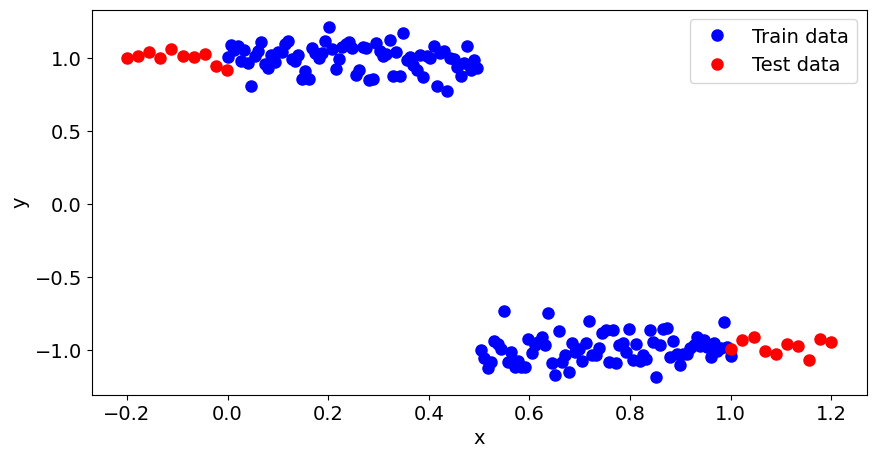

In [2]:
# Plotting the data for visualization
plt.figure(figsize=(10, 5))
plt.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), 'bo', label='Train data')
plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), 'ro', label='Test data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [3]:
from gp.deepgp import DeepGPModel
from gpytorch.mlls import DeepApproximateMLL

# 4-layer deep GP model
# Train the deep GP model
deep_gp = DeepGPModel(train_x_shape=x_train.shape,
                      hidden_layers_config=[
                        {"output_dims": 1, "mean_type": "linear"},
                        {"output_dims": 1, "mean_type": "linear"},
                        {"output_dims": 1, "mean_type": "linear"},
                        {"output_dims": None, "mean_type": "constant"}
                     ],
                     num_inducing_points=128)
deep_gp = deep_gp.cuda()

deep_gp.train()
deep_gp.likelihood.train()

optimizer = torch.optim.Adam(deep_gp.parameters(), lr=0.01)
mll = DeepApproximateMLL(gpytorch.mlls.VariationalELBO(deep_gp.likelihood, deep_gp, y_train.numel()))

y_train_ = y_train.squeeze(1)

training_iterations = 500
for i in range(training_iterations):
    with gpytorch.settings.num_likelihood_samples(10):
        optimizer.zero_grad()
        output = deep_gp(x_train)
        loss = -mll(output, y_train_)
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            print(f'Iteration {i + 1}/{training_iterations} - Loss: {loss.item()}')

Iteration 100/500 - Loss: 0.8600410714021806
Iteration 200/500 - Loss: 0.4113637917513055
Iteration 300/500 - Loss: -0.008848051622518982
Iteration 400/500 - Loss: -0.32475947568149943
Iteration 500/500 - Loss: -0.39035731490692616


In [4]:
# Train the variational GP model
var_gp = SingleTaskVariationalGP(train_X=x_train, train_Y=y_train, inducing_points=128)
var_gp = var_gp.cuda()
var_gp.train()
var_gp.likelihood.train()

optimizer = torch.optim.Adam(var_gp.parameters(), lr=0.01)
mll = gpytorch.mlls.VariationalELBO(var_gp.likelihood, var_gp.model, y_train.numel())

y_train_ = y_train.squeeze(1)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = var_gp(x_train)
    loss = -mll(output, y_train_)
    loss.backward()
    optimizer.step()
    if (i + 1) % 100 == 0:
        print(f'Iteration {i + 1}/{training_iterations} - Loss: {loss.item()}')

Iteration 100/500 - Loss: 0.924259312288928
Iteration 200/500 - Loss: 0.12927616603041375
Iteration 300/500 - Loss: 0.06951511711203351
Iteration 400/500 - Loss: 0.05256156472536315
Iteration 500/500 - Loss: 0.04878116520612345


In [5]:
from botorch.models import SingleTaskGP

gp = SingleTaskGP(train_X=x_train, train_Y=y_train)
gp = gp.cuda()

optimizer = torch.optim.Adam(var_gp.parameters(), lr=0.01)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = gp(x_train)
    loss = -mll(output, y_train_)
    loss.backward()
    optimizer.step()
    if (i + 1) % 100 == 0:
        print(f'Iteration {i + 1}/{training_iterations} - Loss: {loss.item()}')


Iteration 100/500 - Loss: 1.4084594934848456
Iteration 200/500 - Loss: 1.4084594934848456
Iteration 300/500 - Loss: 1.4084594934848456
Iteration 400/500 - Loss: 1.4084594934848456
Iteration 500/500 - Loss: 1.4084594934848456


In [6]:
# Warning: does depend on global variables
def predict_and_plot_deep_gp(model, train_loader, test_loader, save_path=None, dpi=300):
    def split_array(arr):
        arr_less_than_zero = arr[arr <= 0]
        arr_greater_than_zero = arr[arr > 0]
        return arr_less_than_zero, arr_greater_than_zero
    
    # Predict on train data
    train_means = torch.tensor([0.])
    train_variances = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            preds = model.posterior(x_batch, observation_noise=False)
            for pred in preds.mean:
                train_means = torch.cat([train_means, pred.cpu()])
            for vars in preds.variance:
                train_variances = torch.cat([train_variances, vars.cpu()])
    train_means = train_means[1:]
    train_variances = train_variances[1:]

    # Predict on test data
    test_means = torch.tensor([0.])
    test_variances = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model.posterior(x_batch, observation_noise=False)
            for pred in preds.mean:
                test_means = torch.cat([test_means, pred.cpu()])
            for vars in preds.variance:
                test_variances = torch.cat([test_variances, vars.cpu()])
    test_means = test_means[1:]
    test_variances = test_variances[1:]

    # Compute the Mean Squared Error (MSE) for test data
    print('Train MAE: {}'.format(torch.mean(torch.abs(train_means - y_train.cpu()))))
    print('Test MAE: {}'.format(torch.mean(torch.abs(test_means - y_test.cpu()))))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), 'k*', label='Training data')
    plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), 'r*', label='Testing data')
    
    plt.plot(x_train.cpu().numpy(), train_means.cpu().numpy(), 'b', label='Train predictions')
    
    less, more = split_array(x_test.squeeze().cpu().numpy())
    plt.plot(less, test_means[0:len(less)].cpu().numpy(), 'r', label='Test predictions')
    plt.plot(more, test_means[len(less):].cpu().numpy(), 'r')

    # Plot training variance as a shaded area
    plt.fill_between(x_train.squeeze().cpu().numpy(),
                     train_means.cpu().numpy() - 2 * train_variances.cpu().numpy() ** 0.5,
                     train_means.cpu().numpy() + 2 * train_variances.cpu().numpy() ** 0.5,
                     color='b', alpha=0.2, label='Train predictive variance')

    
    # Plot test variance as a shaded area
    plt.fill_between(less,
                     test_means[0:len(less)].cpu().numpy() - 2 * test_variances[0:len(less)].cpu().numpy() ** 0.5,
                     test_means[0:len(less)].cpu().numpy() + 2 * test_variances[0:len(less)].cpu().numpy() ** 0.5,
                     color='r', alpha=0.2, label='Test predictive variance')
    plt.fill_between(more,
                     test_means[len(less):].cpu().numpy() - 2 * test_variances[len(less):].cpu().numpy() ** 0.5,
                     test_means[len(less):].cpu().numpy() + 2 * test_variances[len(less):].cpu().numpy() ** 0.5,
                     color='r', alpha=0.2)
    plt.legend()
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

Train MAE: 1.031157308381099
Test MAE: 0.987014312349158


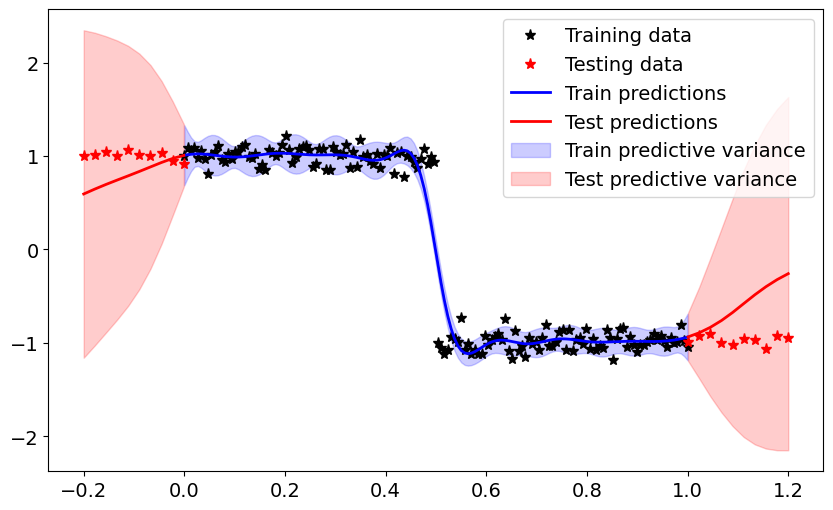

In [7]:
# Predict and plot for Variational GP
predict_and_plot_deep_gp(var_gp, train_loader, test_loader, save_path="vargp")

Train MAE: 1.0286151138459168
Test MAE: 1.006651259693126


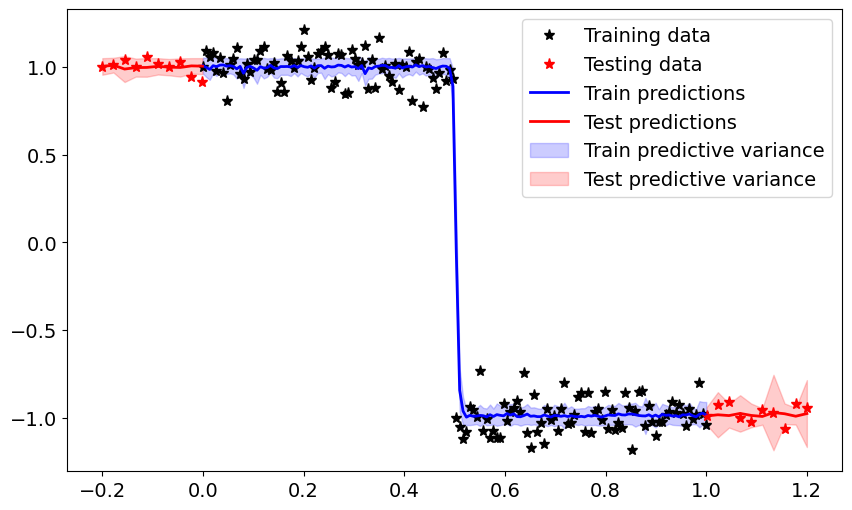

In [8]:
predict_and_plot_deep_gp(deep_gp, train_loader, test_loader, save_path="deep_gp")

Train MAE: 1.0165893511224264
Test MAE: 1.037224505896246


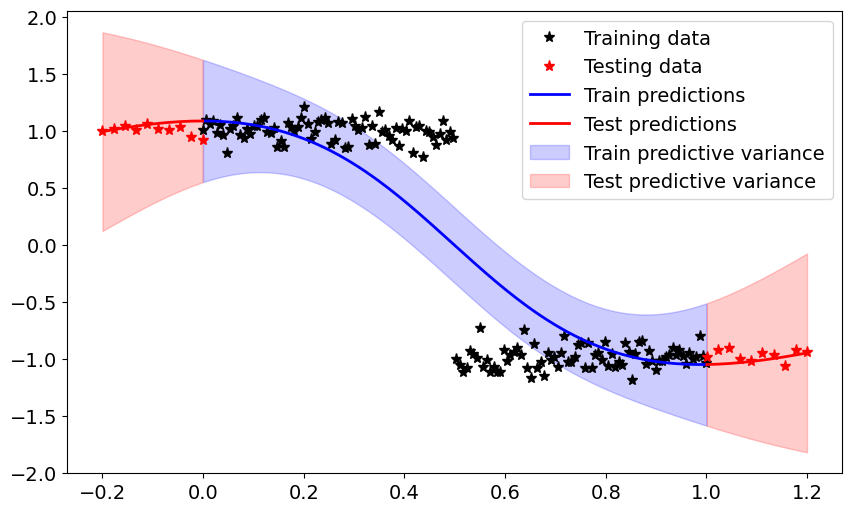

In [9]:
predict_and_plot_deep_gp(gp, train_loader, test_loader, save_path="gp")

### Visualizing the prediction for each layer in the deep GP

In [10]:
from gp.deepgplayers import DeepGPMultivariateNormal
import matplotlib.pyplot as plt

def predict_and_plot_deep_gp_layers(model, x_train, y_train, x_test, y_test):
    def split_array(arr):
        arr_less_than_zero = arr[arr < 0]
        arr_greater_than_zero = arr[arr > 0]
        return arr_less_than_zero, arr_greater_than_zero
    
    model.eval()
    model.likelihood.eval()
    
    with torch.no_grad():
        model(x_train)
        intermediate_outputs = model.get_intermediate_outputs()
        
    with torch.no_grad():
        model(x_test)
        intermediate_outputs_test = model.get_intermediate_outputs()

    num_layers = len(intermediate_outputs)
    
    plt.figure(figsize=(12, 6 * num_layers))
    
    less, more = split_array(x_test.squeeze().cpu().numpy())
    
    for i, layer_output in enumerate(intermediate_outputs, 1):
        layer_output = DeepGPMultivariateNormal(distribution=layer_output)
        
        # print(layer_output.mean.squeeze(1).shape)
        layer_mean = layer_output.mean.squeeze(1).cpu().numpy()
        layer_var = layer_output.variance.squeeze(1).cpu().numpy()
        
        plt.subplot(num_layers, 1, i)
        plt.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), 'k*', label='Train data')
        plt.plot(x_train.cpu().numpy(), layer_mean, 'b', label=f'Layer {i} Mean')
        plt.fill_between(
            x_train.cpu().numpy().squeeze(),
            layer_mean - 2 * layer_var ** 0.5,
            layer_mean + 2 * layer_var ** 0.5,
            color='b', alpha=0.2, label=f'Layer {i} Variance'
        )
        
        plt.title(f'Predictions of Layer {i}')

        
    for i, layer_output in enumerate(intermediate_outputs_test, 1):
        layer_output = DeepGPMultivariateNormal(distribution=layer_output)
        
        layer_mean_test = layer_output.mean.squeeze(1).cpu().numpy()
        layer_var_test = layer_output.variance.squeeze(1).cpu().numpy()
        
        plt.subplot(num_layers, 1, i)
        plt.plot(less, y_test[0:len(less)].cpu().numpy(), 'r*', label='Test data')
        plt.plot(more, y_test[len(less):].cpu().numpy(), 'r*')
        plt.plot(less, layer_mean_test[0:len(less)], 'r', label=f'Layer {i} Mean')
        plt.plot(more, layer_mean_test[len(less):], 'r')
        
                # Plot test variance as a shaded area
        plt.fill_between(less,
                         layer_mean_test[0:len(less)] - 2 * layer_var_test[0:len(less)] ** 0.5,
                         layer_mean_test[0:len(less)] + 2 * layer_var_test[0:len(less)] ** 0.5,
                         color='r', alpha=0.2, label='Test predictive variance')
        plt.fill_between(more,
                         layer_mean_test[len(less):] - 2 * layer_var_test[len(less):] ** 0.5,
                         layer_mean_test[len(less):] + 2 * layer_var_test[len(less):] ** 0.5,
                         color='r', alpha=0.2)

    plt.legend()
    plt.savefig("Y", dpi=300)
    plt.show()
    

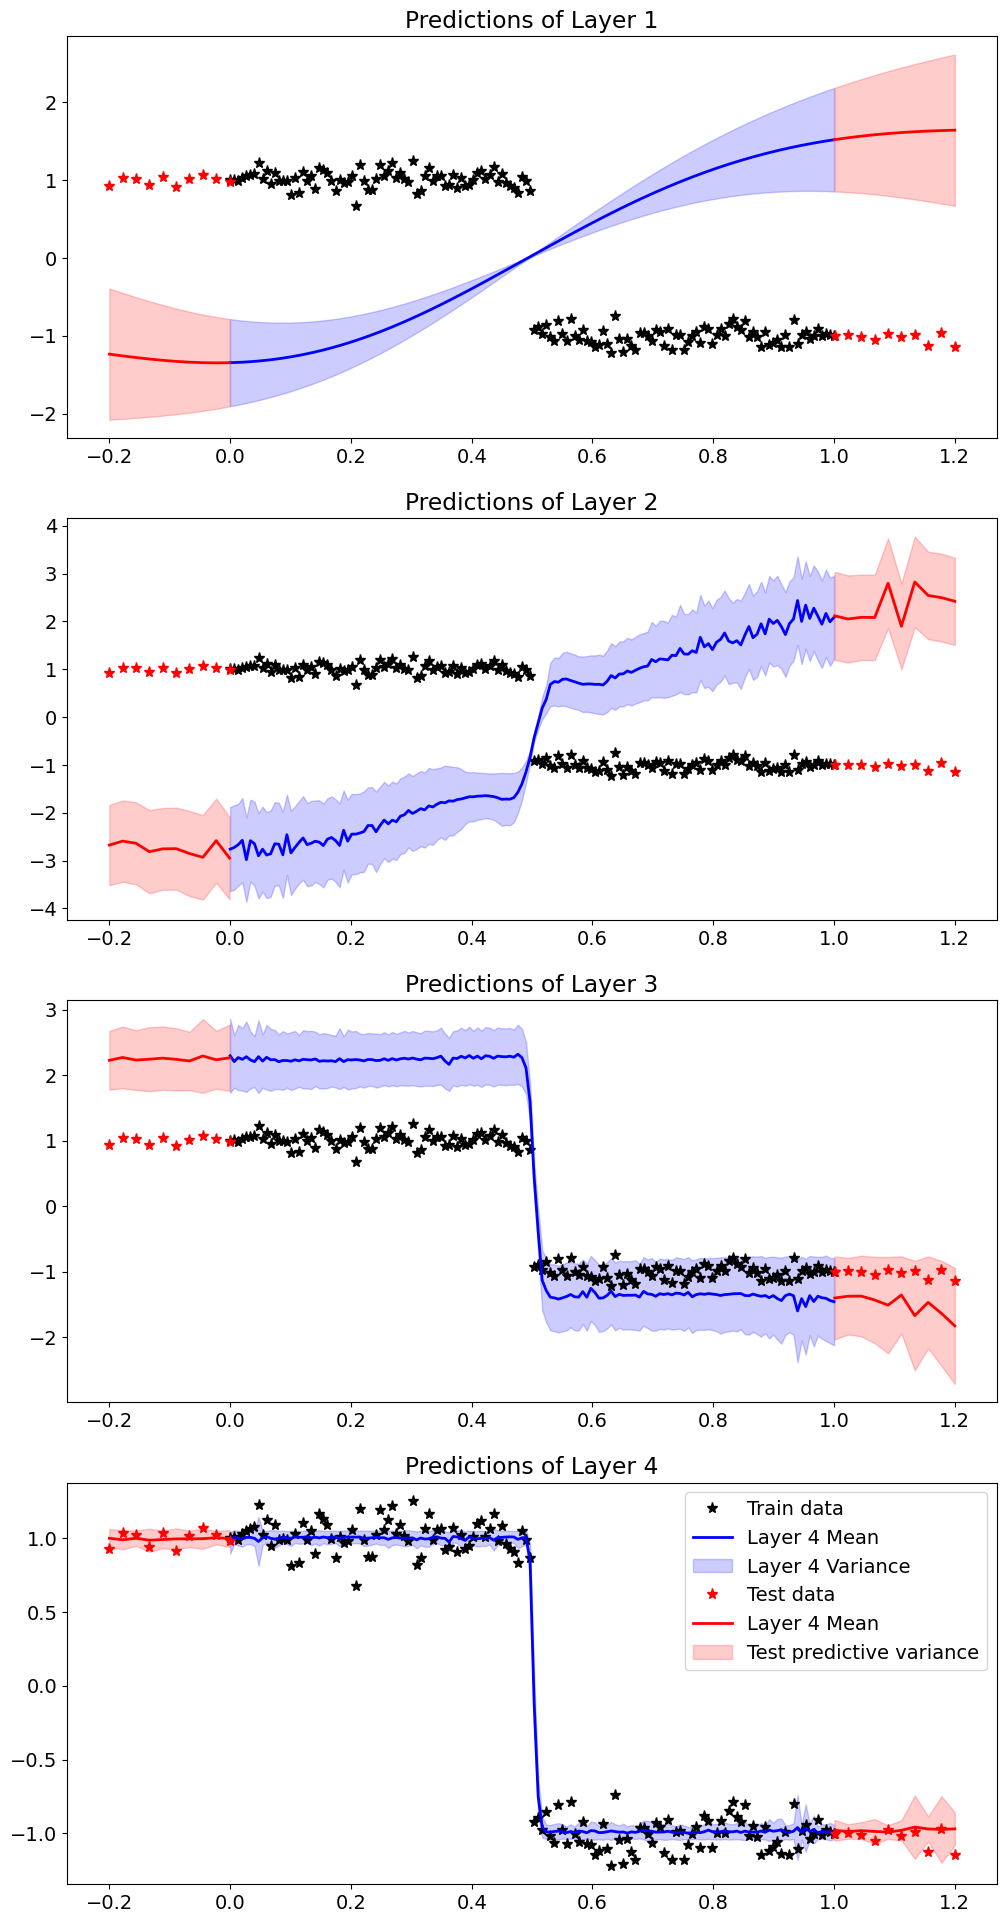

In [50]:
# Example usage
predict_and_plot_deep_gp_layers(deep_gp, x_train, y_train, x_test, y_test)